Subtask4

In [0]:
import numpy as np
import os
import time
import gensim.models.keyedvectors as word2vec
import re
from fever_io import load_dataset_json
from math import *
import random

/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH = '/content/gdrive/My Drive/IRDM_CHFX2/'

In [0]:
def sigmoid(inX):
    '''
    This Sigmoid function is used as a threshold function and mapping variables to between 0 and 1.
    '''
    if inX < 0:
        return 1 - 1/(1 + exp(inX))
    else:
        return 1/(1 + exp(-inX))

In [0]:
# def loadtrainData():
     '''
     This funtion is used to read the training data without any sampling.
     I tried the performance of this method and because of the negative result I do not use it in the final model.
     '''
#    train_x = []
#    train_y = []
#    fileIn = open(PATH + 'traindata_Subtask4.txt')
#    for line in fileIn.readlines():
#        lineArr = line.strip().split()
#        train_x.append([float(lineArr[i]) for i in range(len(lineArr) - 1)])
#        train_y.append(int(lineArr[-1]))
#    return np.mat(train_x), np.mat(train_y).transpose()

In [0]:
# def loadtrainData_oversampling():
     '''
     This funtion is used to read the training data with over sampling.
     I tried the performance of this method and because of the negative result I do not use it in the final model.
     '''
#    pre_x = []
#    pre_y = []
#    fileIn = open(PATH + 'traindata_Subtask4.txt')
#    for line in fileIn.readlines():
#        lineArr = line.strip().split()
#        pre_x.append([float(lineArr[i]) for i in range(len(lineArr) - 1)])
#        pre_y.append(int(lineArr[-1]))
#    ros = RandomOverSampler(random_state=0)
#    sampl_x, sampl_y = ros.fit_sample(pre_x, pre_y)
#    return np.mat(sampl_x),np.mat(sampl_y).transpose()

In [0]:
def loadtrainData_undersampling():
    '''
    This funtion is used to read the training data with under sampling.
    In my training set, it including 153 positive samples and 3201 negative samples. By using this function, we can get all the positive samples and the same number of negative samples.
    '''
    train = []
    fileIn = open(PATH + 'traindata_Subtask4.txt')
    for line in fileIn.readlines():
        lineArr = line.strip().split()
        train.append([float(lineArr[i]) for i in range(len(lineArr))])
   
    pos = []
    neg = []
    for i in train:
        if i[-1] == 1.0:
            pos.append(i)
        else:
            neg.append(i)
    slice1 = random.sample(neg, len(pos))
    data = pos + slice1
    train_x=[]
    train_y=[]
    y = []
    for line in data:
        train_x.append([float(line[i]) for i in range(len(line)-1)])
        y.append([int(line[-1])])
    for i in range(len(y)):
        train_y.append(y[i][0])
    return np.mat(train_x), np.mat(train_y).transpose()

In [0]:
def loaddevData():
    '''
    This funtion is used to read the top 10 claims in the dev set.
    ''' 
    dev_x = []
    dev_y = []
    fileIn = open(PATH + 'devdata_Subtask4.txt')
    for line in fileIn.readlines():
        lineArr = line.strip().split()
        dev_x.append([float(lineArr[i]) for i in range(len(lineArr) - 1)])
        dev_y.append(int(lineArr[-1]))
    return np.mat(dev_x), np.mat(dev_y).transpose()

In [0]:
def trainLogRegres(train_x, train_y, opts):
    '''
    This function is the logistic regresion model with stochastic gradient descent.
    The input is the train_x, the label 'train_y' and the smooth method. I tried two different method in the model.
    The output is the weights that using for prediciton and I also print the train loss and training time to analyse the effect of learning rate.
    '''
    startTime = time.time() ## calculate training time

    numSamples, numFeatures = np.shape(train_x)
    alpha = opts['alpha']
    maxIter = opts['maxIter']
    weights = np.ones((numFeatures, 1))


    for k in range(maxIter):
        if opts['optimizeType'] == 'stocGradDescent':  ## stochastic gradient descent
            for i in range(numSamples):
                output = sigmoid(train_x[i, :] * weights)
                loss = train_y[i, 0] - output
                weights = weights + alpha * train_x[i, :].transpose() * loss
        elif opts['optimizeType'] == 'smoothStocGradDescent':  ## smooth stochastic gradient descent. randomly select samples to optimize for reducing cycle fluctuations.
            dataIndex = list(range(numSamples))
            for i in range(numSamples):
                alpha = 4.0 / (1.0 + k + i) + 0.01
                randIndex = int(np.random.uniform(0, len(dataIndex)))
                output = sigmoid(train_x[randIndex, :] * weights)
                loss = train_y[randIndex, 0] - output
                weights = weights + alpha * train_x[randIndex, :].transpose() * loss
                del (dataIndex[randIndex])
    print(loss)
    print('Congratulations, training complete! Took %fs!' % (time.time() - startTime))
    return weights

In [0]:
def testLogRegres(weights, dev_x, dev_y):
    '''
    This function is used to predict the data by the logistice model.
    The input is the weights of logistics model, the dev_x and the label 'dev_y'.
    The output is the prediction result.
    '''
    predict_y = []
    numSamples, numFeatures = np.shape(dev_x)
    for i in range(numSamples):
        if sigmoid(dev_x[i, :] * weights) > 0.5:
            label = 1
        else:
            label = 0
        predict_y.append(label)
    print('Congratulations, testing complete!')
    return predict_y

In [0]:
def Subtask4_pre_train_1(path):
    '''
    This function is the same as the function for data pre-processing for query-likelihood unigram language model in Subtask3.
    '''
    n_dict = {}
    files = os.listdir(path)
    for i in files:
        with open(os.path.join(path, i)) as fp:
            lines = fp.readlines()
            for line in lines:
                text = eval(line)['text'] ## extract data from the field of 'text'.
                words = text.split(' ')
                for w in words:
                    w = w.replace("-LRB-","").replace("-RRB-","").replace("-LSB-","").replace("-RSB-","").replace("--","")
                    w = re.sub("[,.。:_=+*&^%$#@!?()<>/`';|]", "", w) ## replace the noisy with space. 
                    if not w in n_dict:
                        n_dict[w] = 1
                    else:
                        n_dict[w] += 1 ## count the frequencies of every term.
    np.save(PATH + "pre_train_1_Subtask4.npy",n_dict)
    print ('save complete')

In [0]:
Subtask4_pre_train_1(PATH + 'data/wiki-pages/wiki-pages/')

save complete


In [0]:
def Subtask4_pre_train_2_Laplace(number):
    '''
    This function is the same as the function for Laplace Smoothing query-likelihood unigram language model in Subtask3.
    '''
    alpha = 0.5

    train_data = load_dataset_json(PATH + 'data/train.jsonl', instance_num = number)
    data = np.load(PATH + 'pre_train_1_Subtask4.npy', allow_pickle=True).item()
    
    id_list = []
    for d in train_data:
        if d['label'] != 'NOT ENOUGH INFO':
            claim_id = d['id']
            id_list.append(claim_id)

    documents ={}
    for x in id_list:
        claim = None
        for d in train_data:
            if d['id'] == x:
                claim = d['claim'][:-1]
                claim = re.sub("[,.。:_=+*&^%$#@!?()<>/`';|]", "", claim)
                claim = claim.split(' ')
                #break

                C = sum(data.values())
                f = []

                files = os.listdir(PATH + 'data/wiki-pages/wiki-pages/')
                for i in files:
                    with open(os.path.join(PATH + 'data/wiki-pages/wiki-pages/', i)) as fp:
                        lines = fp.readlines()
                        for line in lines:
                            text = eval(line)['text'].split(' ')
                            tmp = 0
                            for w in claim:
                                if w in text:
                                    p = (text.count(w) + 1) / (len(text) + 1)
                                else:
                                    if w in data:
                                        p = alpha * (data[w] + 1) / (C + len(data))
                                    else:
                                        p = 0.01
                                tmp += log(p)
                            f.append((eval(line)['id'], tmp))
                f.sort(key=lambda x:x[1], reverse=True)
                evidence = []
                for i in range(5):
                    name = f[i][0]
                    evidence.append(name)
                documents[d['claim']] = evidence
    np.save(PATH + "pre_train_2_Subtask4.npy",documents)
    print ('save complete')

In [0]:
Subtask4_pre_train_2_Laplace(150)

In [0]:
def Subtask4_pre_train_3():
    '''
    The output is a dictionary which the key is the document 'id' that appear in any of the claim's five similar documents and the value is 'lines' in wiki-pages.
    '''
    train_data = np.load(PATH + 'pre_train_2_Subtask4.npy', allow_pickle=True).item()

    evidence=[]
    for d in train_data.items():
        for i in range(5):
            evidence.append(d[1][i])

    files = os.listdir(PATH + 'data/wiki-pages/wiki-pages/')
    documents = {}
    for i in files:
        with open(os.path.join(PATH + 'data/wiki-pages/wiki-pages/', i)) as fp:
            lines = fp.readlines()
            for line in lines:
                line = eval(line)
                if line['id'] in evidence:
                    text = line['lines']
                    documents[line['id']] = text
    with open(PATH + 'pre_train_3_Subtask4.txt', 'w', encoding='utf-8') as f:
        f.write(str(documents))

In [0]:
Subtask4_pre_train_3()

In [0]:
def Subtask4_pre_train_4():
    '''
    The output is a list which the structure is [claim, evidence document, sentence_number].
    '''
    evidence_data = load_dataset_json(PATH + 'data/train.jsonl', instance_num = 200)
    evi = []
    for i in evidence_data:
        for j in i['evidence']:
            evi.append([i['claim'], j[0][2], j[0][3]])
    evi_new=[]
    for e in evi:
        if e not in evi_new:
            evi_new.append(e)
    
    with open(PATH + 'pre_train_4_Subtask4.txt', 'w', encoding='utf-8') as f:
        f.write(str(evi_new))

In [0]:
Subtask4_pre_train_4()

In [0]:
def Subtask4_pre_train_5():
    '''
    The out put is the embedding result of claim, sentence and the label which is totally 601 dimmensions
    I use word2vec for embedding and the structure of output for each claim and the sentence is [embedding claim_300 dimmensions, embedding each sentence in 5 documents_300 dimmensions, label]
    If the sentence is the evidence sentence show in the train set, the label is 1. Else the label is 0.
    '''
    with open(PATH + 'pre_train_4_Subtask4.txt', encoding='utf-8') as fi:
        evi = eval(fi.read())

    train_data = np.load(PATH + 'pre_train_2_Subtask4.npy', allow_pickle=True).item()
    model = word2vec.KeyedVectors.load_word2vec_format(PATH + "data/GoogleNews-vectors-negative300.bin", binary=True)

    with open(PATH + 'pre_train_3_Subtask4.txt', encoding='utf-8') as f:
        document = eval(f.read())

    with open(PATH + 'traindata_Subtask4.txt', 'w') as fp:
        for data in train_data.items():
                claim = data[0]
                claim = re.sub("[-,.。:_=+*&^%$#@!?()<>/`';|]", "", claim)
                claim = claim.split(' ')
                claim = list(filter(lambda x: x in model.vocab, claim))
                Vi = []
                for i in range(len(claim)):
                    Vi.append(model[claim[i]])

                V = np.zeros(len(Vi[0]))
                for i in range(len(claim)):
                    for j in range(len(Vi[0])):
                        V[j] = V[j] + Vi[i][j]

                rms = 0
                for i in range(len(Vi[0])):
                    rms += V[i] * V[i]
                rms = np.sqrt(rms / len(Vi[0]))

                for i in range(len(Vi[0])):
                    V[i] = V[i] / rms
                V = V.astype(str).tolist()
                
                for doc in data[1]:
                    lines = document[doc].split('\n')
                    for k in range(len(lines)):
                        label = [data[0], doc, k]
                        line = document[doc].split('\n')[k]
                        if line != str(k) + '\t':
                            line = line.replace(str(k) + '\t', '')
                            line = line.split('\t')[0]
                            line = re.sub("[-,.。:_=+*&^%$#@!?()<>/`';|]", "", line)
                            line = line.split(' ')
                            line = list(filter(lambda x: x in model.vocab, line))
                            if len(line) != 0:
                                Vi = []
                                for i in range(len(line)):
                                    Vi.append(model[line[i]])

                                V1 = np.zeros(len(Vi[0]))
                                for i in range(len(line)):
                                    for j in range(len(Vi[0])):
                                        V1[j] = V1[j] + Vi[i][j]

                                rms = 0
                                for i in range(len(Vi[0])):
                                    rms += V1[i] * V1[i]
                                rms = np.sqrt(rms / len(Vi[0]))

                                for i in range(len(Vi[0])):
                                    V1[i] = V1[i] / rms
                                V1 = V1.astype(str).tolist()
                                
                                if label in evi:
                                    fp.write(' '.join(V) + ' ' + ' '.join(V1) + ' 1' + '\n')
                                else:
                                    fp.write(' '.join(V) + ' ' + ' '.join(V1) + ' 0' + '\n')

In [0]:
Subtask4_pre_train_5()

In [0]:
### For the following 4 funtions, they are the same as the above 4 functions. The only different is that it is for the 10 claims in the development set.

In [0]:
def Subtask4_pre_dev_2_Laplace(index):
    alpha = 0.5

    dev_data = load_dataset_json(PATH + 'data/dev.jsonl', instance_num=20)
    data = np.load(PATH + 'pre_train_1_Subtask4.npy', allow_pickle=True).item()
    
    documents ={}
    index_list = index
    for x in index_list:
        claim = None
        for d in dev_data:
            if d['id'] == x:
                claim = d['claim'][:-1]
                claim = re.sub("[,.。:_=+*&^%$#@!?()<>/`';|]", "", claim)
                claim = claim.split(' ')
                #break

                C = sum(data.values())
                f = []

                files = os.listdir(PATH + 'data/wiki-pages/wiki-pages/')
                for i in files:
                    with open(os.path.join(PATH + 'data/wiki-pages/wiki-pages/', i)) as fp:
                        lines = fp.readlines()
                        for line in lines:
                            text = eval(line)['text'].split(' ')
                            tmp = 0
                            for w in claim:
                                if w in text:
                                    p = (text.count(w) + 1) / (len(text) + 1)
                                else:
                                    if w in data:
                                        p = alpha * (data[w] + 1) / (C + len(data))
                                    else:
                                        p = 0.01
                                tmp += log(p)
                            f.append((eval(line)['id'], tmp))
                f.sort(key=lambda x:x[1], reverse=True)
                evidence = []
                for i in range(5):
                    name = f[i][0]
                    evidence.append(name)
                documents[d['claim']] = evidence
    np.save(PATH + "pre_dev_2_Subtask4.npy",documents)
    print ('save complete')

In [0]:
index = [
137334,
111897,
89891,
181634,
219028,
108281,
204361,
54168,
105095,
18708
]

Subtask4_pre_dev_2_Laplace(index)

In [0]:
def Subtask4_pre_dev_3():
    dev_data = np.load(PATH + 'pre_dev_2_Subtask4.npy', allow_pickle=True).item()

    evidence=[]
    for d in dev_data.items():
        for i in range(5):
            evidence.append(d[1][i])

    files = os.listdir(PATH + 'data/wiki-pages/wiki-pages/')
    documents = {}
    for i in files:
        with open(os.path.join(PATH + 'data/wiki-pages/wiki-pages/', i)) as fp:
            lines = fp.readlines()
            for line in lines:
                line = eval(line)
                if line['id'] in evidence:
                    text = line['lines']
                    documents[line['id']] = text
    with open(PATH + 'pre_dev_3_Subtask4.txt', 'w', encoding='utf-8') as f:
        f.write(str(documents))

In [0]:
Subtask4_pre_dev_3()

In [0]:
def Subtask4_pre_dev_4():
    evidence_data = load_dataset_json(PATH + 'data/dev.jsonl', instance_num = 20)
    evi = []
    for i in evidence_data:
        for j in i['evidence']:
            evi.append([i['claim'], j[0][2], j[0][3]])
    evi_new=[]
    for e in evi:
        if e not in evi_new:
            evi_new.append(e)
    
    with open(PATH + 'pre_dev_4_Subtask4.txt', 'w', encoding='utf-8') as f:
        f.write(str(evi_new))

In [0]:
Subtask4_pre_dev_4()

In [0]:
def Subtask4_pre_dev_5():
    with open(PATH + 'pre_dev_4_Subtask4.txt', encoding='utf-8') as fi:
        evi = eval(fi.read())

    train_data = np.load(PATH + 'pre_dev_2_Subtask4.npy', allow_pickle=True).item()
    model = word2vec.KeyedVectors.load_word2vec_format(PATH + "data/GoogleNews-vectors-negative300.bin", binary=True)

    with open(PATH + 'pre_dev_3_Subtask4.txt', encoding='utf-8') as f:
        document = eval(f.read())

    with open(PATH + 'devdata_Subtask4.txt', 'w') as fp:
        for data in train_data.items():
                claim = data[0]
                claim = re.sub("[-,.。:_=+*&^%$#@!?()<>/`';|]", "", claim)
                claim = claim.split(' ')
                claim = list(filter(lambda x: x in model.vocab, claim))
                Vi = []
                for i in range(len(claim)):
                    Vi.append(model[claim[i]])

                V = np.zeros(len(Vi[0]))
                for i in range(len(claim)):
                    for j in range(len(Vi[0])):
                        V[j] = V[j] + Vi[i][j]

                rms = 0
                for i in range(len(Vi[0])):
                    rms += V[i] * V[i]
                rms = np.sqrt(rms / len(Vi[0]))

                for i in range(len(Vi[0])):
                    V[i] = V[i] / rms
                V = V.astype(str).tolist()
                
                for doc in data[1]:
                    lines = document[doc].split('\n')
                    for k in range(len(lines)):
                        label = [data[0], doc, k]
                        line = document[doc].split('\n')[k]
                        if line != str(k) + '\t':
                            line = line.replace(str(k) + '\t', '')
                            line = line.split('\t')[0]
                            line = re.sub("[-,.。:_=+*&^%$#@!?()<>/`';|]", "", line)
                            line = line.split(' ')
                            line = list(filter(lambda x: x in model.vocab, line))
                            if len(line) != 0:
                                Vi = []
                                for i in range(len(line)):
                                    Vi.append(model[line[i]])

                                V1 = np.zeros(len(Vi[0]))
                                for i in range(len(line)):
                                    for j in range(len(Vi[0])):
                                        V1[j] = V1[j] + Vi[i][j]

                                rms = 0
                                for i in range(len(Vi[0])):
                                    rms += V1[i] * V1[i]
                                rms = np.sqrt(rms / len(Vi[0]))

                                for i in range(len(Vi[0])):
                                    V1[i] = V1[i] / rms
                                V1 = V1.astype(str).tolist()

                                if label in evi:
                                    fp.write(' '.join(V) + ' ' + ' '.join(V1) + ' 1' + '\n')
                                else:
                                    fp.write(' '.join(V) + ' ' + ' '.join(V1) + ' 0' + '\n')

In [0]:
Subtask4_pre_dev_5()

In [0]:
'''
The result below use the undersampling method and save as 'train_x.dat' and 'train_y.dat'.
You may not get the same result if you sampling again because the sampling result is different every time.
As an alternative, you need to use the following code to read the sampling data I saved after got the best result to reproduce the result
code:
'''
print("step 1: load data...")
train_x = np.load(PATH + 'train_x.dat', allow_pickle=True)
train_y = np.load(PATH + 'train_y.dat', allow_pickle=True)
dev_x, dev_y = loaddevData()

print("step 2: training...")
opts = {'alpha': 0.0001, 'maxIter': 5000, 'optimizeType': 'smoothStocGradDescent'}
optimalWeights = trainLogRegres(train_x, train_y, opts)

print("step 3: testing...")
predict_y = testLogRegres(optimalWeights, dev_x, dev_y)

In [0]:
'''
This part is using to load the train data, dev data and training the model and prediction the result.
I used it to try different sampling method and the best result is show below and the data sampling for this result is save as 'train_x.dat' and 'train_y.dat'
Please use the code above to read the undersampling data to reproduce the result below because the sampling result is different every time and you may not get the same result if you sampling again.
'''
# ## step 1: load data
# print("step 1: load data...")
# train_x, train_y = loadtrainData_undersampling()
# dev_x, dev_y = loaddevData()
# ## step 2: training
# print("step 2: training...")
# opts = {'alpha': 0.0001, 'maxIter': 5000, 'optimizeType': 'smoothStocGradDescent'}
# optimalWeights = trainLogRegres(train_x, train_y, opts)
# ## step 3: testing
# print("step 3: testing...")
# predict_y = testLogRegres(optimalWeights, dev_x, dev_y)

step 1: load data...
step 2: training...
2.4976221091321804e-09
Congratulations, training complete! Took 97.173146s!
step 3: testing...
Congratulations, testing complete!


In [0]:
from sklearn.metrics import roc_curve, auc, mean_squared_error, accuracy_score, zero_one_loss
import matplotlib.pyplot as plt
def check_fit(truth, prob):
    '''
    This function is using the plot the ROC curve and print the RMSE, accuracy, AUC and test loss.
    The input is the prediction result of dev data and the label of dev data
    '''
    fpr, tpr, _ = roc_curve(truth, prob)     ## drop_intermediate:(default=True) 
    roc_auc = auc(fpr, tpr)   ## calculate the AUC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.1, 1.05])
    plt.ylim([-0.1, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show() 
    print('results are RMSE, accuracy, ROC, loss function')
    print(sqrt(mean_squared_error(truth, prob)), accuracy_score(truth, prob), roc_auc,zero_one_loss(truth,prob))

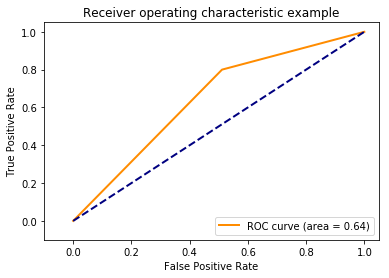

results are RMSE, accuracy, ROC, loss function
0.7033355181304509 0.5053191489361702 0.6443820224719101 0.49468085106382975


In [0]:
check_fit(dev_y, predict_y)

Subtask5

In [0]:
def precision_score(y_true, y_pred):
    '''
    The y_true is the label of dev data and the y_pred is the prediciton of the model
    '''
    return ((y_true==1)*(y_pred==1)).sum()/(y_pred==1).sum()

def recall_score(y_true, y_pred):
    '''
    The y_true is the label of dev data and the y_pred is the prediciton of the model
    '''
    return ((y_true==1)*(y_pred==1)).sum()/(y_true==1).sum()

def f1_score(y_true, y_pred):
    '''
    The y_true is the label of dev data and the y_pred is the prediciton of the model
    '''
    num = 2 * precision_score(y_true, y_pred)*recall_score(y_true, y_pred)
    deno = (precision_score(y_true, y_pred)+recall_score(y_true, y_pred))
    return num/deno

In [0]:
dev_y = np.array(np.squeeze(dev_y).tolist())
predict_y = np.array(predict_y)

print(precision_score(dev_y, predict_y))
print(recall_score(dev_y, predict_y))
print(f1_score(dev_y, predict_y))

0.08080808080808081
0.8
0.1467889908256881
